In [1]:
import sys
sys.path.append('../src')

In [2]:
from gso.manifolds import AlgebraicManifold, AlgebraicManifoldBis, plot_manifold
from gso.graph_sampling import GraphSampler, GraphSamplerBis
from gso.signal_generation import SignalGenerator

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Algebraic Manifold

In [4]:
num_equations = 2
num_variables = 4
max_degree = 4
seed = 22

M = AlgebraicManifold(num_equations, num_variables, max_degree, seed)

print(M)
print(M.intrinsic_dim)
print(M.get_equations())
print(M.get_jacobian())

AlgebraicManifold(num_equations=2, num_variables=4, max_degree=4, random_seed=22)
2
[-0.583078925282315*x0 + 0.461013293572337*x1**3 + 0.718363997042688*x2 + 0.693417971415281*x3, -0.458934333404338*x0**3 - 0.9772068378269*x1 + 0.623901841077373*x2**4 - 0.692700720411484*x3**4]
Matrix([[-0.583078925282315, 1.38303988071701*x1**2, 0.718363997042688, 0.693417971415281], [-1.37680300021301*x0**2, -0.977206837826900, 2.49560736430949*x2**3, -2.77080288164594*x3**3]])


In [5]:
plot_manifold(M.equations, M.variables)

TypeError: plot_manifold() missing 1 required positional argument: 'variables'

## Point Sampling

Uniform sampling is required for $L\to\Delta_\mathcal{M}$. Non-uniform sampling would converge to a weighted Laplace-Beltrami operator:
$$
\Delta_\rho f=\Delta_\mathcal{M}f+\frac{\nabla\rho}{\rho}\cdot \nabla f
$$
where $\rho$ is the sampling density. We use random affine slicing to avoid ambient space bias, which produces samples with density proportional to the Riemannian measure.

In [5]:
start_time = time.perf_counter()
point_cloud = M.sample(99)
elapsed = time.perf_counter() - start_time

print(f"Function took {elapsed:.4f} seconds")

print(len(point_cloud))
for x in point_cloud:
    assert M._is_smooth(x)

Function took 2.9065 seconds
99


In [6]:
start_time = time.perf_counter()
D = M.compute_geodesics(point_cloud)
elapsed = time.perf_counter() - start_time

print(f"Function took {elapsed:.4f} seconds")


print("First 5x5 geodesic distances:")
print(D[:5, :5])

Function took 2.3611 seconds
First 5x5 geodesic distances:
[[       0.          1528966.440371   14496842.10501271   119880.12597658
   1332532.95206685]
 [ 1528966.440371          0.          8229117.9070748   3362507.33865371
   1263413.87272274]
 [14496842.10501271  8229117.9070748         0.         13430872.82343021
   4211348.17777974]
 [  119880.12597658  3362507.33865371 13430872.82343021        0.
    835133.00066659]
 [ 1332532.95206685  1263413.87272274  4211348.17777974   835133.00066659
         0.        ]]


In [8]:
def visualize_matrix(matrix, n: int = 100, figsize = (5, 4), title = None) -> None:
    """
    Visualize weighted matrices as a square heatmap of size n by n.
        
    Args:
        n: Number of points to include in the visualization
    """
    n = min(n, matrix.shape[0])
    
    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(matrix[:n, :n], square=True, annot=False, cmap='viridis', ax=ax)
    if title is not None:
        ax.set_title(title)
    plt.show()

In [ ]:
visualize_distances(D, title='Geodesic Distance Matrix')

In [ ]:
plot_manifold(M.equations, M.variables, points=point_cloud)

## Graph Generator

Create a graph structure (sparse matrix: csr_matrix), e.g. from SBM model. Then create a weighted graph based on the structure and a manifold. 

The graph Laplacian $L$ approximates the generator of heat diffusion on the manifold $\mathcal{M}$. For a smooth function $f$ on $\mathcal{M}$:

$$
-c_n L f \approx \Delta_{\mathcal{M}} f
$$

where $c_n = \epsilon^{-(d/2 + 1)}$ scales the Laplacian to match the continuous operator. This links discrete graph dynamics to the PDE:

$$
\frac{\partial u}{\partial t} = \Delta_{\mathcal{M}} u
$$

governing heat flow on $\mathcal{M}$.

The Gaussian kernel $W_{ij} = \exp(-||x_i -x_j||^2/\epsilon)$ approximates the **manifold heat kernel**:

$$
G_\epsilon(x,y) \propto \epsilon^{-d/2} \exp\left(-\frac{d_\mathcal{M}(x,y)^2}{4\epsilon}\right)
$$

where $d_\mathcal{M}$ is the geodesic distance. This ensures spectral convergence of $-c_n L$ to $\Delta_{\mathcal{M}}$ as $n \to \infty$.

For $L \to \Delta_{\mathcal{M}}$, three conditions must hold:

| Condition | Mathematical Requirement | Purpose |
|-----------|---------------------------|---------|
| Bandwidth decay | $\epsilon(n) \sim \left(\frac{\log n}{n}\right)^{\frac{2}{d+2}}$ | Balances locality vs connectivity |
| Kernel normalization | $c_n = \epsilon^{-(d/2 + 1)}$ | Compensates for kernel decay |
| Sparsity | $\text{avg degree} \sim \log n$ | Avoids overconnection |

The critical rates ensure:
$$
\sup_{x_i} | -c_n L f(x_i) - \Delta_{\mathcal{M}} f(x_i) | \xrightarrow{n \to \infty} 0
$$

**1. Bandwidth Calculation**

$$
\epsilon = C_M \left( \frac{\log n}{n} \right)^{\frac{2}{d + 2}}
$$

- $C_M$: Manifold curvature constant
- Derived from eigen-convergence rate optimization

**2. Weight Assignment**

For edge $(i,j)$ in sparse adjacency $S$:
$$
W_{ij} = \exp\left(-\frac{||x_i -x_j||^2}{\epsilon}\right) \cdot S_{ij}
$$

**3. Implementation Steps**

1. Sample $\{x_i\} \subset \mathcal{M}$ uniformly
2. Compute pairwise distances for edges in $S$
3. Set $\epsilon$ via above formula
4. Construct $W$ using Gaussian kernel
5. Form $L = D - W$ and scale by $c_n$

This workflow guarantees spectral convergence to the Laplace-Beltrami operator.

In [5]:
import networkx as nx
from scipy.sparse import csr_matrix

def create_sbm(sizes: list, probs: list, seed=None) -> csr_matrix:
    """
    Generate SBM graph as compressed sparse row matrix.
    
    Parameters:
    sizes : list of ints        # Nodes per community
    probs : 2D list of floats   # Inter/intra-community edge probabilities
    seed  : int (optional)      # Random seed
    
    Returns:
    csr_matrix                  # Sparse adjacency matrix
    """
    g = nx.stochastic_block_model(sizes, probs, seed=seed)
    return nx.adjacency_matrix(g).tocsr()

In [6]:
sizes = [33, 33, 33]
probs = np.array([[0.3, 0.01, 0.02],
                  [0.01, 0.25, 0.03],
                  [0.02, 0.03, 0.2]])
structure = create_sbm(sizes, probs, seed)

In [9]:
L, W, point_cloud, epsilon = GraphSamplerBis().create_weighted_graph(M, 99, structure)

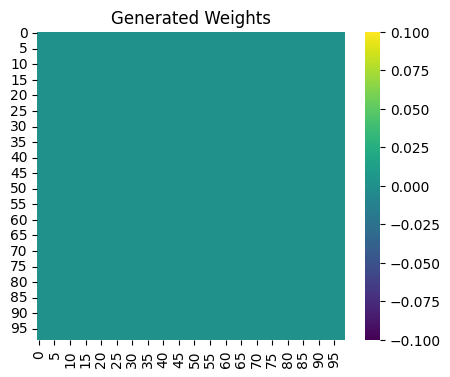

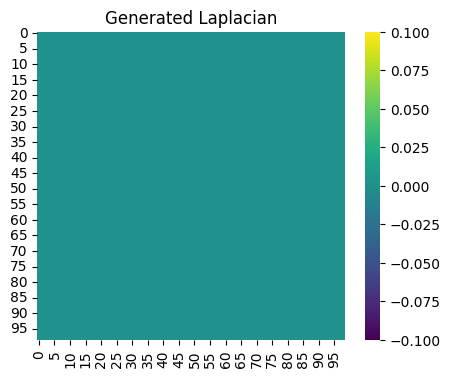

In [10]:
visualize_matrix(W.toarray(), 99, title = "Generated Weights")
visualize_matrix(L.toarray(), 99, title = "Generated Laplacian")

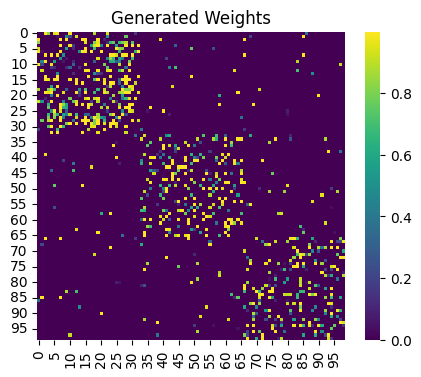

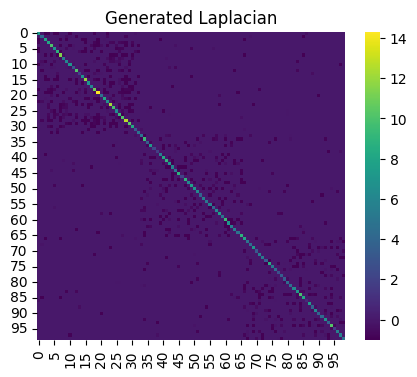

In [9]:
num_equations = 2
num_variables = 4
max_degree = 4
seed = 22

M = AlgebraicManifoldBis(num_equations, num_variables, max_degree, seed)

L, W, point_cloud, epsilon = GraphSamplerBis().create_weighted_graph_from_structure(M, structure)
visualize_matrix(W.toarray(), 99, title = "Generated Weights")
visualize_matrix(L.toarray(), 99, title = "Generated Laplacian")

## Signal Generation

## First Inference 

Learn weights from SBM structured graph signals, with and without structure knowledge.

## First Experiment

Generate signals using the Kuramoto model, then try to apply MLE-type of learning method.

## Second Experiment

Get a first idea of how it scales with network size.

## Third Experiment

Physics based spectrum (WDS without pumps is easier parralel) vs data-based